In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import ensemble
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
import sys

In [215]:
# file path of data file
data_path = './ncds_sweep4/tab/ncds4.tab'

# read data file into Pandas DataFrame
# delimiter is tab
# use column 'ncdsid' as index
data = pd.read_csv(data_path, delimiter='\t').set_index('ncdsid')

Pos. = 772	Variable = n5765	Variable label = 4I Fits,convulsions-ever called epileptic

This variable is  numeric, the SPSS measurement level is ordinal.

	Value label information for n5765
	Value = 1	Label = YES
	Value = 2	Label = NO
	Value = 8	Label = DONT   KNOW

In [216]:
# file path of explain file
explain_path = '/Users/hung-yiwu/Documents/AC209a_project/data/ncds_sweep4/mrdoc/allissue/ncds4_ukda_data_dictionary.rtf'

# open explain file
explain = open(explain_path, 'r')

# read the whole file as a single giant string
explain_text = explain.read()

# target string
target_string = 'the SPSS measurement level is'

# locate target string in the whole file
target_loc = [m.start() for m in re.finditer(target_string, explain_text)]
target_loc = target_loc[1:]

In [217]:
data_cp = data.copy()
for index, loc in enumerate(target_loc):
    char = explain_text[loc+len(target_string)+10]
    unique = data.iloc[:,index].unique()
    unique_type = [type(i) for i in unique]
    
    if data.columns[index] == 'n5765':
        # response variable
        continue
    elif char == 'O' or char == 'o' or char == 'N' or char == 'n' \
        or 'region' in data.columns[index]\
        or type('str') in unique_type:
        # it is SPSS data type ORDINAL or NOMINAL
        # it is categorical data
        data.iloc[:,index] = preprocessing.LabelEncoder().fit_transform(\
            data.iloc[:,index].values)
        
    # display progress
    sys.stdout.write('\r{}/{}'.format(index+1, len(data.columns)))
    sys.stdout.flush()

1472/1472

In [218]:
y_df = data['n5765']
x_df = data.drop('n5765', axis=1)

x = x_df.values
y = np.array([1 if i == '1' else 0 for i in y_df.values])

rf_model = ensemble.RandomForestClassifier()
rf_model.fit(x, y)
model_score = model_selection.cross_val_score(rf_model, x, y).mean()
null_model_score = float(len(y[y==0]))/float(len(y))

print 'model score: {}'.format(np.round(model_score, 4))
print 'null model score: {}'.format(np.round(null_model_score, 4))

model score: 0.9689
null model score: 0.9936


In [219]:
importance = rf_model.feature_importances_.reshape(-1,1)
feature = x_df.columns.values.reshape(-1,1)

f = pd.DataFrame(np.concatenate([feature, importance], axis = 1),\
                 columns = ['feature name', 'importance'])
f.sort('importance', ascending = False, inplace = True)
print f.head(15)

     feature name  importance
770         n5766   0.0438039
772         n5769   0.0391674
771         n5768   0.0377213
1452      icdcat6   0.0210897
769         n5764    0.020632
757         n5749   0.0125374
831         n5914  0.00885769
1380     estfamg1   0.0087615
1246      pregmar  0.00819785
1074        ec228   0.0077941
755         n5747  0.00724849
832         n5915  0.00710724
873         n5969  0.00697569
394         n4917  0.00690405
868         n5962  0.00618537


/Users/hung-yiwu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


n5768: convulsions-prescribed medicines

n5769: convulsions-medical supervision

n5766: convulsions-age at last attack

n5764: Fits,convulsions since 16th birthday

n4139: Whether registered disabled page one

**n6026: Malaise-11 twitching of face,head,shldrs**

n5747: Disability-limits getting out alone

meanjob: Mean length of all ft & pt jobs (mths)

n5745: Disability-limits getting about house

**n5959: Whether voted in 1979 general election**

n5744: Disability-limits washing or dressing

**subhq: Sub.of  high qual or current course**

**ecactim2: Total months econ active-approx def**

**n4223pw: 1st job - pay per week**

n6458: Disability of respondent (1)

In [220]:
pay = data_cp['n4223pw'].apply(lambda i: 0 if i == ' ' else float(i)).values
pay_df = pd.DataFrame(np.concatenate([pay.reshape(-1,1), y.reshape(-1,1)],\
                                     axis = 1), columns = ['pay', 'epilepsy'])
print pay_df.shape
pay_df = pay_df[np.logical_and(pay <> 0, pay <> -3)]
print pay_df.shape

(12537, 2)
(11807, 2)


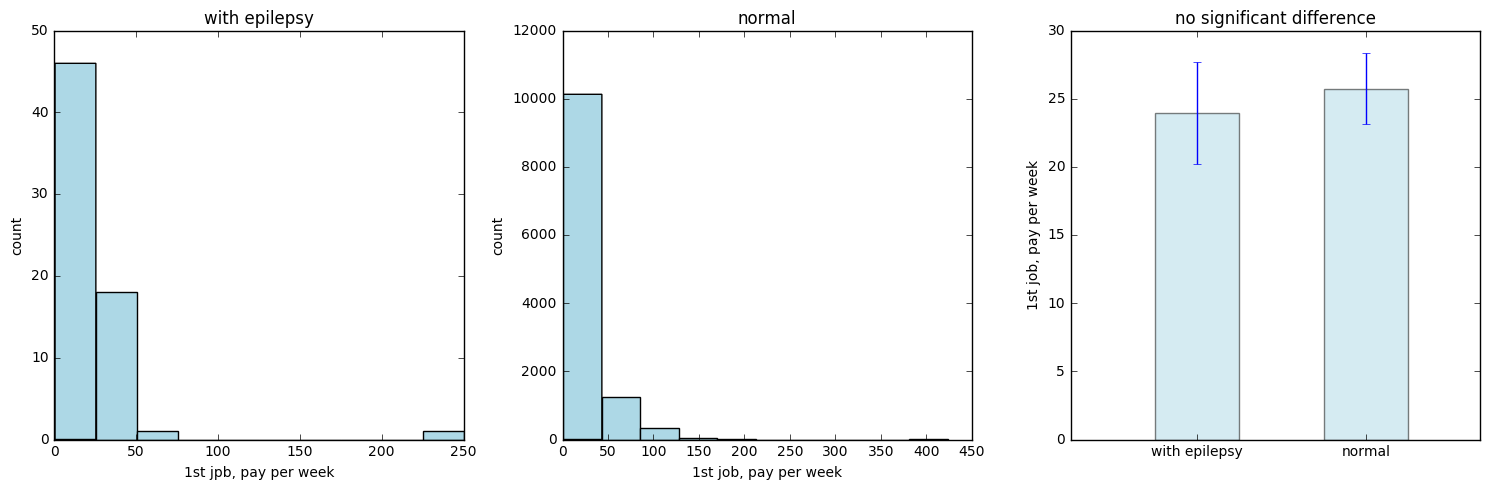

In [228]:
pay_epilepsy = pay_df[pay_df['epilepsy'] == 1]['pay'].values
pay_normal = pay_df[pay_df['epilepsy'] == 0]['pay'].values

fig, axs = plt.subplots(1,3, figsize = (15,5))

axs[0].hist(pay_epilepsy, color = 'lightblue')
axs[0].set_xlabel('1st jpb, pay per week')
axs[0].set_ylabel('count')
axs[0].set_title('with epilepsy')
axs[1].hist(pay_normal, color = 'lightblue')
axs[1].set_xlabel('1st job, pay per week')
axs[1].set_ylabel('count')
axs[1].set_title('normal')

means = [np.mean(pay_epilepsy), np.mean(pay_normal)]
stderrs = [np.std(pay_epilepsy)/np.sqrt(float(pay_epilepsy.shape[0])),\
           np.std(pay_normal)/np.sqrt(float(pay_epilepsy.shape[0]))]

ind = np.array([0, 0.7])
width = 0.35
axs[2].bar(ind+width, means, width, yerr = stderrs, color = 'lightblue', alpha = 0.5)
axs[2].set_xticks(ind+width*1.5)
axs[2].set_xticklabels(['with epilepsy', 'normal'])
axs[2].set_ylabel('1st job, pay per week')
axs[2].set_title('no significant difference')
axs[2].set_xlim([0,1.7])

fig.tight_layout()
plt.show()
plt.savefig('payperweek.png')

In [223]:
subhq = data_cp['subhq'].apply(lambda i: -1 if i == ' ' else float(i)).values
subhq_df = pd.DataFrame(np.concatenate([subhq.reshape(-1,1), y.reshape(-1,1)],\
                                     axis = 1), columns = ['subhq', 'epilepsy'])
print subhq_df.shape
subhq_df = subhq_df[subhq <> -1]
print subhq_df.shape

(12537, 2)
(3121, 2)


In [224]:
print subhq_df.groupby('epilepsy')['subhq'].value_counts(normalize = True)

epilepsy  subhq
0.0       7.0      0.353168
          6.0      0.100032
          8.0      0.088131
          1.0      0.084593
          2.0      0.076552
          9.0      0.075587
          3.0      0.066903
          10.0     0.065294
          11.0     0.045352
          4.0      0.025410
          5.0      0.018977
1.0       7.0      0.333333
          3.0      0.166667
          8.0      0.166667
          6.0      0.083333
          9.0      0.083333
          10.0     0.083333
          11.0     0.083333
Name: subhq, dtype: float64


([<matplotlib.patches.Wedge at 0x1236f6b90>,
  <matplotlib.text.Text at 0x11e0cfbd0>])

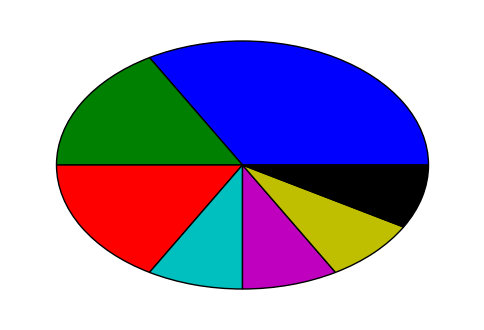

In [225]:
plt.pie(subhq_df[subhq_df['epilepsy'] == 1]['subhq'].value_counts())